In [1]:

import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

import transformers
from sentence_transformers import SentenceTransformer

#- Plotting
import matplotlib.pyplot as plt
import seaborn as sns

import nomic
#- Data
from nomic import AtlasDataset

#- Processing
from fuzzywuzzy import fuzz
from unidecode import unidecode
import re
import datetime
import gc

nomic.login("nk-2LSEn5FB5h04Dn0pFLuZ9jDw7ZaMbPpYPV88wbKKASc")

import json
import os
import pickle



dataset = AtlasDataset('hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-10-08')
bill_meta = pickle.load(open('bill_meta.p', 'rb'))

df = dataset.maps[0].data.df
embds = dataset.maps[0].embeddings.latent

df.head()

/cis/home/tchen94/anaconda3/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
2024-10-31 15:48:34.806 | INFO     | nomic.dataset:__init__:768 - Loading existing dataset `hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-10-08`.
2024-10-31 15:48:35.642 | WARNING  | nomic.data_operations:df:923 - Converting to pandas dataframe. This may materialize a large amount of data into memory.
2024-10-31 15:48:35.645 | INFO     | nomic.data_operations:_download_data:902 - Downloading data
100%|██████████| 129/129 [00:01<00:00, 83.42it/s] 
2024-10-31 15:48:43.588 | INFO     | nomic.data_operations:_load_data:872 - Loading data
100%|██████████| 129/129 [00:15<00:00,  8.38it/s]
2024-10-31 15:49:06.784 | INFO     | nomic.data_operations:_download_latent:550 - Downloading

,tweetId,postedAt,name,state,party,twitter_lower,chamber,years,source,id,text
0,1065633444502224896,2018-11-22 15:49:46.338,Ken Buck R-CO,CO,R,repkenbuck,House,2017_2018,PolitWoops,1203633,Happy #Thanksgiving! I hope everyone has a cha...
1,1479108462504136704,2022-01-06 15:11:52.624,Kat Cammack R-FL,FL,R,repkatcammack,House,2021_2022,PolitWoops,2857207,"RT @MorningsMaria: .@RepKatCammack: ""The Democ..."
2,85108215381102592,2011-06-26 22:12:34.438,Dennis Ross R-FL,FL,R,repdennisross,House,2011_2012,PolitWoops,35353,@CEP_Observer will have to check that out.
3,925691081026621440,2017-11-01 11:48:46.882,Richard Hudson R-NC,NC,R,reprichhudson,House,2017_2018,PolitWoops,954870,RT @BGClubCab: Thanks to @CharlotteWBB for hel...
4,1435963943533568000,2021-09-09 13:50:57.715,Chip Roy R-TX,TX,R,repchiproy,House,2021_2022,PolitWoops,2324693,RT @chiproytx: No. https://t.co/STZW0DdDz1


In [2]:
def capitalize_first_letters(name, delimiter=' '):
    recon=''
    chunks = name.split(delimiter)
    
    for chunk in chunks:
        recon += chunk[0].upper() + chunk[1:] + ' '
        
    return recon.strip()

def get_tweet_start(text, n_characters=30):
    chunks = text.split(' ')

    text_ = chunks[0]
    len_text = len(text_)

    c=1
    while len_text < n_characters and c < len(chunks)-1:
        text_ += ' ' + chunks[c]
        len_text = len(text_)
        c+=1

    return text_, len(chunks) - c

def remove_quotes(tweet, quote_list = ['"', "'", b'\xe2\x80\x9c'.decode()]):
    removed_first_quote = False
    while not removed_first_quote:
        if tweet in quote_list:
            tweet = tweet[1:]
        else:
            removed_first_quote=True

    removed_last_quote = False
    while not removed_first_quote:
        if tweet[-1] in quote_list:
            tweet = tweet[:-1]
        else:
            removed_last_quote=True
            
    if tweet[0] in quote_list:
        tweet = tweet[1:]
    if tweet[-1] in quote_list:
        tweet = tweet[:-1]
        
    return tweet.strip()

In [3]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="cuda:0",
)

embedding_model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

<All keys matched successfully>


In [4]:
#- Should be able to re-factor so that we are not keeping n_bills copies of embeddings / text

congress_name_list= list(df['name'].unique())   
n_congresspersons = len(congress_name_list)

name_to_standardized_name = {}

for name in congress_name_list:
    chunks = name.lower().split(' ')[:2]
    if ',' in chunks[0]:
        standardized_name = chunks[1] + '_' + chunks[0][:-1]
    else:
        standardized_name = chunks[0] + '_' + chunks[1]

    name_to_standardized_name[name] = unidecode(standardized_name)
standardized_name_list = list(name_to_standardized_name.values())
    
standardize_vote = {
    'Yea': 'yea', 
    'Aye': 'yea', 
    'Nay': 'nay', 
    'No': 'nay', 
    'Not Voting': 'not voting',
    'Present': 'not voting'
    }
    
cp_metadata_by_bill = {}
text_dict = {}
embd_dict = {}
for bill in bill_meta:
    cp_metadata_by_bill[bill] = {}
    
    if bill_meta[bill]['house_vote_id'] == '':
        HOUSE = False
        congress_name_list_house = []
    else:
        HOUSE = True
        
    if bill_meta[bill]['senate_vote_id'] == '':
        SENATE = False
        congress_name_list_senate = []
        
    else:
        SENATE = True
    
    
    if HOUSE:
        year, month, day = bill_meta[bill]['house_vote_date'].split('-')
        house_t = pd.Timestamp(year=int(year), month=int(month), day=int(day))
        
        house_vote_id = bill_meta[bill]['house_vote_id']
        
        df_house = pd.read_csv(f'/cis/home/tchen94/tianyi/congressional-twin/experiments/tianyi/Data/{house_vote_id}.csv', header=0)
        congress_name_list_house = df_house['matched-name'].unique()
        congress_name_list_house = [name for name in congress_name_list_house if pd.notnull(name)][:-1]
        
        
    if SENATE:
        year, month, day = bill_meta[bill]['senate_vote_date'].split('-')
        senate_t =  pd.Timestamp(year=int(year), month=int(month), day=int(day))
        
        senate_vote_id = bill_meta[bill]['senate_vote_id']
    
        df_senate = pd.read_csv(f'/cis/home/tchen94/tianyi/congressional-twin/experiments/tianyi/Data/{senate_vote_id}.csv', header=0)
        congress_name_list_senate = df_senate['matched-name'].unique()
        congress_name_list_senate = [name for name in congress_name_list_senate if pd.notnull(name)][:-1]

    t_dict = {'house': house_t, 'senate': senate_t}
    
    #- Add all congress persons in Atlas dataframe to name_to_standardized_name
    for name in congress_name_list:
        party=df[df['name'] == name]['party'].values[0].lower()
        
        if name in congress_name_list_house:
            vote = standardize_vote[df_house[df_house['matched-name'] == name]['vote'].values[0]]
            chamber='house'
        elif name in congress_name_list_senate:
            vote = standardize_vote[df_senate[df_senate['matched-name'] == name]['vote'].values[0]]
            chamber='senate'
        else:
            vote='n/a'
            chamber=df[df['name'] == name]['chamber'].values[0].lower()
        
        standardized_name = name_to_standardized_name[name]
                    
        cp_metadata_by_bill[bill][standardized_name] = {'party': party, 'vote': vote, 'chamber': chamber}

    text_dict[bill] = {name: {'pre-t': [], 'post-t': []} for name in standardized_name_list}
    embd_dict[bill] = {name: {'pre-t': [], 'post-t': []} for name in standardized_name_list}

    
#- this could be way faster
for i, embd in enumerate(tqdm(embds)):
    name = df['name'][i]
    posted_at = df['postedAt'][i]
    party = df['party'][i].lower()
    chamber = df['chamber'][i].lower()
    
    standardized_name = name_to_standardized_name[name]
    
    for bill in cp_metadata_by_bill:
        if standardized_name not in cp_metadata_by_bill[bill]:
            vote = 'n/a'
            cp_metadata_by_bill[bill][standardized_name] = {'party': party, 'vote': vote, 'chamber': chamber}

        if posted_at > t_dict[chamber]:
            key='post-t'
        else:
            key='pre-t'

        text_dict[bill][standardized_name][key].append(df['text'][i])
        embd_dict[bill][standardized_name][key].append(embd)

100%|██████████| 3214913/3214913 [11:31<00:00, 4649.86it/s] 


In [5]:
with open('cmds_dict_inference.p', 'rb') as file:
    cmds_dict = pickle.load(file)

In [6]:
list(cmds_dict[bill]['retrieved'].keys())==list(cmds_dict[bill]['generated'].keys())

True

In [7]:
for bill in bill_meta:
    if bill_meta[bill]['senate_vote_id'] != '':
        print(bill, bill_meta[bill]['senate_vote_id'])

117-HR-1319 117-2021_s110
117-HR-4346 117-2022_s271
118-HR-7888 118-2024_s150
118-HR-3746 118-2023_s146


In [8]:
np.random.seed(1)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score

score=accuracy_score

def get_indices_by_class(y):
    unique = np.unique(y)
            
    indices_by_class ={}
    for c in unique:
        indices_by_class[c] = np.where(y == c)[0]
        
    return indices_by_class

def get_stratified_folds(y, n_folds):
    indices_by_class = get_indices_by_class(y)
    folds = {i: {'train': [], 'test': []} for i in range(n_folds)}
        
    for c, indices in indices_by_class.items():
        test_per_fold = int(len(indices) *  (1 / n_folds))
        
        for i in range(n_folds):
            folds[i]['test']+= list(indices[i*test_per_fold: (i+1)*test_per_fold])
            
        
    for i in range(n_folds):
        folds[i]['train'] = np.array([j for j in range(len(y)) if j not in folds[i]['test']])
        folds[i]['test'] = np.array(folds[i]['test'])
        
    return folds

def get_stratified_sample(y, p):
    indices_by_class = get_indices_by_class(y)
    
    inds = []
    for c, indices in indices_by_class.items():
        temp = np.random.choice(indices, size=int(p * len(indices)), replace=False)
        inds += list(temp)
    
    return inds


def get_party_line(y, party_list): 
    party_types = np.unique(party_list)
    
    party_to_vote_dict = {}
    for party_type in party_types:
        unique, counts = np.unique(y[party_list == party_type], return_counts=True)
        party_to_vote_dict[party_type] = unique[np.argmax(counts)]
        
    return party_to_vote_dict

In [134]:
from graspologic.plot import pairplot, heatmap

party_color_dict = {'d': 'tab:blue', 'r': 'tab:red', 'i': 'tab:green', 'n/a': 'k'}
vote_color_dict = {'nay': 'tab:red', 'yea': 'tab:green', 'not voting': 'tab:olive', 'n/a': 'k'}

party_by_bill = {}
vote_by_bill = {}
chamber_by_bill = {}
name_list_2 = {}

for bill in cmds_dict:
    if bill_meta[bill]['house_vote_id'] == '':
        continue
    
    name_list = list(cmds_dict[bill]['retrieved'].keys())
    cmds_retrieved = np.array(list(cmds_dict[bill]['retrieved'].values()))
    cmds_generated = np.array(list(cmds_dict[bill]['generated'].values()))

    party_by_bill[bill] = np.array([cp_metadata_by_bill[bill][name]['party'] for name in name_list])
    vote_by_bill[bill] = np.array([cp_metadata_by_bill[bill][name]['vote'] for name in name_list])
    name_list_2[bill] = name_list
    chamber_by_bill[bill] = np.array([cp_metadata_by_bill[bill][name]['chamber'] for name in name_list]) 
    
    party_list = party_by_bill[bill]

In [190]:
## tuning the knn k parameter:
n_folds=50
n_neighbors_list = [1,3,5,9,15,21,31,51,101]

best_score_generated = {}
argbest_score_generated = {}
std_best_generated = {}

best_score_retrieved = {}
argbest_score_retrieved = {}
std_best_retrieved = {}

std_results_dict = {}
average_results_dict = {}

for bill in cp_metadata_by_bill:
    if bill_meta[bill]['house_vote_id'] == '' or bill_meta[bill]['senate_vote_id'] =='':
        continue

    average_results_dict[bill] = {}
    std_results_dict[bill] = {}
    
    best_score_generated[bill] = -1
    argbest_score_generated[bill] = -1
    std_best_generated[bill] = -1
    
    
    best_score_retrieved[bill] = -1
    argbest_score_retrieved[bill] = -1
    std_best_retrieved[bill] = -1
    
    vote_list = vote_by_bill[bill]
    party_list = party_by_bill[bill]
    
    voter_inds_house = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'house'])
    #voter_inds_senate = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'senate'])

    n_voters_house = len(voter_inds_house)
    #n_voters_senate = len(voter_inds_senate)
        
    folds = get_stratified_folds(vote_list[voter_inds_house], n_folds)
    
    results_dict = {k: {'retrieved': [], 'generated': [], 'majority': [], 'party-line': []} for k in n_neighbors_list}
    for k in n_neighbors_list:
        for mc in range(n_folds):
            train_inds = folds[mc]['train']
            test_inds = folds[mc]['test']
            
            for type_, cmds in cmds_dict[bill].items():
                model = KNeighborsClassifier(n_neighbors=k)
                
                cmds = np.array(list(cmds_dict[bill][type_].values()))
                model.fit(cmds[voter_inds_house][train_inds], vote_list[voter_inds_house][train_inds])

                y_pred = model.predict(cmds[voter_inds_house][test_inds])
                results_dict[k][type_].append(score(vote_list[voter_inds_house][test_inds], y_pred))


            if k != n_neighbors_list[-1]:
                continue
                
            #- majority
            unique, return_counts = np.unique(vote_list[voter_inds_house][train_inds], return_counts=True)
            y_pred = len(test_inds) * [unique[np.argmax(return_counts)]]
            results_dict[k]['majority'].append(score(vote_list[voter_inds_house][test_inds], y_pred))


            #- party line vote
            y_pred = [get_party_line(vote_list[voter_inds_house], party_list[voter_inds_house])[p] for p in party_list[voter_inds_house][test_inds]]
            results_dict[k]['party-line'].append(score(vote_list[voter_inds_house][test_inds], y_pred))

        if np.mean(results_dict[k]['generated']) > best_score_generated[bill]:
            best_score_generated[bill] = np.mean(results_dict[k]['generated'])
            argbest_score_generated[bill] = k
            std_best_generated[bill] = np.std(results_dict[k]['generated'])
            
        if np.mean(results_dict[k]['retrieved']) > best_score_retrieved[bill]:
            best_score_retrieved[bill] = np.mean(results_dict[k]['retrieved'])
            argbest_score_retrieved[bill] = k
            std_best_retrieved[bill] = np.std(results_dict[k]['retrieved'])
            
    for type_, results in results_dict[k].items():
        average_results_dict[bill][type_] = np.mean(results)
        std_results_dict[bill][type_] = np.std(results)
        
    average_results_dict[bill]['retrieved'] = best_score_retrieved[bill]
    average_results_dict[bill]['generated'] = best_score_generated[bill]
    
    std_results_dict[bill]['retrieved'] = std_best_retrieved[bill]
    std_results_dict[bill]['generated'] = std_best_generated[bill]
    
    print(average_results_dict[bill])
    print()

{'retrieved': 0.5, 'generated': 0.84, 'majority': 0.5, 'party-line': 1.0}

{'retrieved': 0.62, 'generated': 0.84, 'majority': 0.5, 'party-line': 0.99}

{'retrieved': 0.6666666666666665, 'generated': 0.7333333333333332, 'majority': 0.6666666666666665, 'party-line': 0.6133333333333334}

{'retrieved': 0.6799999999999998, 'generated': 0.7066666666666666, 'majority': 0.6666666666666665, 'party-line': 0.6666666666666665}



117-HR-1319 0.84
117-HR-4346 0.84
118-HR-7888 0.7333333333333332
118-HR-3746 0.7066666666666666


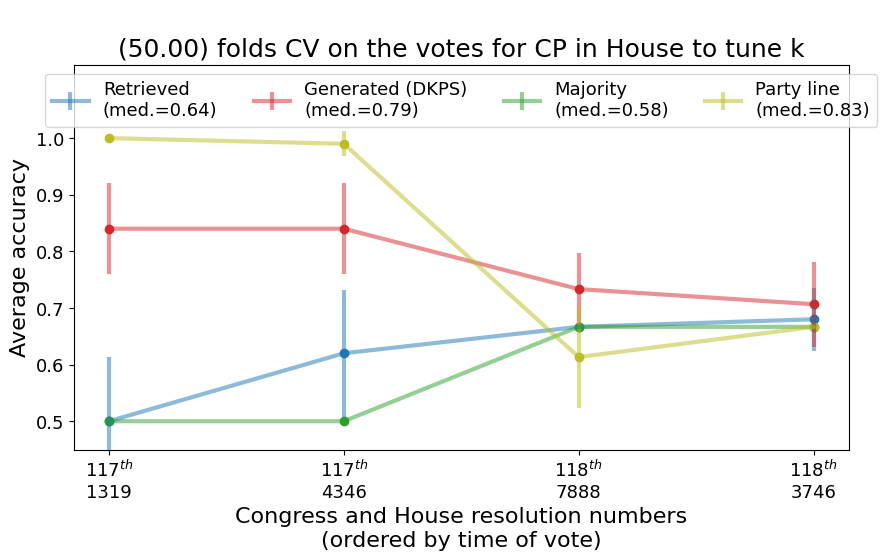

In [191]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
bill_list = list(average_results_dict.keys())
# bill_list.remove('118-HR 1435')

method_list = list(average_results_dict[bill_list[0]].keys())

bill_labels= []
for bill in bill_list:
    if bill == '118-HR 1435':
        bill_labels.append(r'118$^{th}$'+'\n1435')
        continue
    split = bill.split('-')
    bill_labels.append(f'{split[0]}' + r'$^{th}$' + '\n' + split[2])

# markers=['*', '^', 'v']
# bill_to_marker = {bill: markers[i] for i, bill in enumerate(bill_list)}

colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:olive']
method_to_color = {method: colors[i] for i, method in enumerate(method_list)}

legend_dict = {
    'retrieved': 'Retrieved', 
    'generated': 'Generated (DKPS)',
    'majority': 'Majority', 
    'party-line': 'Party line'
}

result_by_method = {method: [] for method in method_list}
std_by_method = {method: [] for method in method_list}
for i, bill in enumerate(bill_list):
    for j, (method, avg) in enumerate(average_results_dict[bill].items()):
        if method == 'generated':
            print(bill, avg)
        ax.scatter(i, avg, color=method_to_color[method])
        result_by_method[method].append(avg)
        std_by_method[method].append(std_results_dict[bill][method])
    
for method in result_by_method:
    median = np.median(result_by_method[method])
    ax.errorbar(range(len(bill_list)), result_by_method[method], yerr=std_by_method[method] / np.sqrt(10), color=method_to_color[method], alpha=0.5, lw=3, 
                label=legend_dict[method]+f'\n(med.={median:1.2f})')
    
ax.set_xticks(range(len(bill_list)), labels=bill_labels)
ax.set_xlabel('Congress and House resolution numbers\n(ordered by time of vote)', fontsize=16)
ax.tick_params(labelsize=13)
ax.set_ylabel('Average accuracy', fontsize=16)
ax.set_title( f'\n({n_folds:1.2f}) folds CV on the votes for CP in House to tune k', fontsize=18)
# ax.set_xlim(-.05, 2.05)
ax.set_ylim(0.45, 1.13)
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.legend(fontsize=13, loc='upper center', ncols=4)


In [184]:
argbest_score_retrieved

{'117-HR-1319': 21, '117-HR-4346': 21, '118-HR-7888': 101, '118-HR-3746': 9}

In [186]:
## predict on the senate vote

results_dict_senate = {'retrieved': [], 'generated': [], 'majority': [], 'party-line': []}

for bill in argbest_score_generated.keys():
    
    ## train on all house votes
    
    vote_list = vote_by_bill[bill]
    party_list = party_by_bill[bill]
    
    voter_inds_house = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'house'])
    voter_inds_senate = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'senate'])
    
    #- majority
    unique, return_counts = np.unique(vote_list[voter_inds_house], return_counts=True)
    y_pred = len(voter_inds_senate) * [unique[np.argmax(return_counts)]]
    results_dict_senate['majority'].append(score(vote_list[voter_inds_senate], y_pred))


    #- party line vote
    y_pred = [get_party_line(vote_list[voter_inds_house], party_list[voter_inds_house])[p if p != 'i' else 'd'] for p in party_list[voter_inds_senate]]
    results_dict_senate['party-line'].append(score(vote_list[voter_inds_senate], y_pred))

    n_voters_house = len(voter_inds_house)
    
    #- generated 
    k = argbest_score_generated[bill]
    model = KNeighborsClassifier(n_neighbors=k)
                
    cmds = np.array(list(cmds_dict[bill]['generated'].values()))
    model.fit(cmds[voter_inds_house], vote_list[voter_inds_house])

    y_pred = model.predict(cmds[voter_inds_senate])
    results_dict_senate['generated'].append(score(vote_list[voter_inds_senate], y_pred))
    
    #-retrieved
    k = argbest_score_retrieved[bill]
    model = KNeighborsClassifier(n_neighbors=k)
    
    cmds = np.array(list(cmds_dict[bill]['retrieved'].values()))
    model.fit(cmds[voter_inds_house], vote_list[voter_inds_house])
    
    y_pred = model.predict(cmds[voter_inds_senate])
    results_dict_senate['retrieved'].append(score(vote_list[voter_inds_senate], y_pred))
    
        
    print(average_results_dict[bill])    

{'retrieved': 0.5, 'generated': 0.84, 'majority': 0.5, 'party-line': 1.0}
{'retrieved': 0.62, 'generated': 0.84, 'majority': 0.5, 'party-line': 0.99}
{'retrieved': 0.6666666666666665, 'generated': 0.7333333333333332, 'majority': 0.6666666666666665, 'party-line': 0.6133333333333334}
{'retrieved': 0.6799999999999998, 'generated': 0.7066666666666666, 'majority': 0.6666666666666665, 'party-line': 0.6666666666666665}
